# GemGIS - Interactively picking points to create a GemPy Model

***Authors: @Arthur Endlein Correia @Alexander Jüstel***

<img src="Data/WorkingAreaGeology.png" width=750>

# Importing Libraries

In [1]:
# import sys
# sys.path.append('C:/Users/alexa/Documents/gemgis')

# import gemgis as gg
# print(gg)
import numpy as np
import geopandas as gpd
import pandas as pd
import xmltodict
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

from bokeh.plotting import figure, output_file, show, Column
from bokeh.models import (
    DataTable, TableColumn,
    PointDrawTool, BoxEditTool, PolyDrawTool,
    ColumnDataSource, GeoJSONDataSource, CustomJSTransform)

from bokeh.layouts import column
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

from bokeh.tile_providers import CARTODBPOSITRON, OSM, get_provider

from bokeh.transform import transform
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
output_notebook()

Loading BokehJS ...

# Defining Functions

In [25]:
def parse_categorized_qml(qml_fname):
    with open(qml_fname, "rb") as f:
        qml = xmltodict.parse(f)
    column = qml["qgis"]["renderer-v2"]["@attr"]
    symbols = {
        symbol["@name"]:{
            prop["@k"]:prop["@v"] for prop in symbol["layer"]["prop"]
        }
        for symbol in qml["qgis"]["renderer-v2"]["symbols"]["symbol"]
    }
    classes = {
        category['@value']:symbols[category['@symbol']]
        for category in qml["qgis"]["renderer-v2"]["categories"]["category"]
    }
    return column, classes

def build_style_dict(column, classes):
    styles = {}
    for cls, style in classes.items():
        *color, opacity = [int(i) for i in style["outline_color"].split(",")]
        *fillColor, fillOpacity = [int(i) for i in style["color"].split(",")]
        color = fillColor
        styles[cls] = {
            "color": f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}",
            "opacity": opacity/255,
            "weight": float(style["outline_width"]),
            "fillColor": f"#{fillColor[0]:02x}{fillColor[1]:02x}{fillColor[2]:02x}",
            "fillOpacity": fillOpacity/255
        }
    return styles

def build_style_callback(column, classes):
    styles = {}
    for cls, style in classes.items():
        *color, opacity = [int(i) for i in style["outline_color"].split(",")]
        *fillColor, fillOpacity = [int(i) for i in style["color"].split(",")]
        color = fillColor
        styles[cls] = {
            "color": f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}",
            "opacity": opacity/255,
            "weight": float(style["outline_width"]),
            "fillColor": f"#{fillColor[0]:02x}{fillColor[1]:02x}{fillColor[2]:02x}",
            "fillOpacity": fillOpacity/255
        }
    def style_callback(feature):
        value = feature["properties"][column]
        return styles[value if value is not None else ""]

    return style_callback

# output_file("tools_point_draw.html")
def bksc(doc):
    p = figure(#x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator",
        match_aspect=True,  # https://stackoverflow.com/a/45961896/1457481
        plot_width=800,
    )
    tile_provider = get_provider(OSM)
    geo_source = GeoJSONDataSource(geojson=geo.to_crs(epsg=3857).to_json())
#     p.background_fill_color = 'lightgrey'

    p.add_tile(tile_provider)
    p.patches('xs','ys', source = geo_source, color="Color", legend_label="Map", line_color ='black', width=0.2)
    area_renderer = p.rect(
        x="x", y="y", width="w", height="h",
        source=area_source,
        fill_color=None,
        line_color="red"
    )
    profile_renderer = p.multi_line('xs', 'ys', source=profile_source, color="red")

    points_renderer = p.text(
        "x", "y",
        text=transform(
            "dipdir",
            CustomJSTransform(
                v_func="""return xs.map(e => e === null || e === ""? "●": "⊦")"""
            )
        ),
        color=transform(
            "unit",
            CustomJSTransform(
                v_func=f"""const cdict={style.color.to_json()};return xs.map(e => {{if(e !== null && e in cdict) return cdict[e]; else return "black";}})"""
            )
        ),
        source=atti_source,
        angle_units="deg", angle=transform(
            "dipdir",
            CustomJSTransform(v_func="""return xs.map(e => -Math.PI/2 - e)""")
        ),
       text_baseline="middle", text_align="center",
        text_font_style="bold", text_font_size="2em")
    columns = [TableColumn(field="x", title="x"),
               TableColumn(field="y", title="y"),
               TableColumn(field='unit', title='unit'),
               TableColumn(field='dipdir', title='dip direction'),
               TableColumn(field='dip', title='dip')]
    table = DataTable(source=atti_source, columns=columns, editable=True, height=200)


#     source.on_change("data", lambda attr, old, new: print("python changed data", new))

    draw_tool = PointDrawTool(renderers=[points_renderer])
    rect_tool = BoxEditTool(renderers=[area_renderer])
    profile_tool = PolyDrawTool(renderers=[profile_renderer])
    # https://docs.bokeh.org/en/latest/docs/reference/models/tools.html?highlight=pointdrawtool#bokeh.models.tools.PointDrawTool
    p.add_tools(draw_tool)
    # https://docs.bokeh.org/en/latest/docs/reference/models/tools.html?highlight=pointdrawtool#bokeh.models.tools.BoxEditTool
    p.add_tools(rect_tool)
    # https://docs.bokeh.org/en/latest/docs/reference/models/tools.html?highlight=pointdrawtool#bokeh.models.tools.PolyDrawTool
    p.add_tools(profile_tool)

    p.toolbar.active_tap = draw_tool
    
    p.legend.location = "top_left"
    p.legend.click_policy="hide"

    doc.add_root(column(p, table))

# Loading Data

## Loading Geological Map with Geopandas

{'init': 'epsg:4647'}


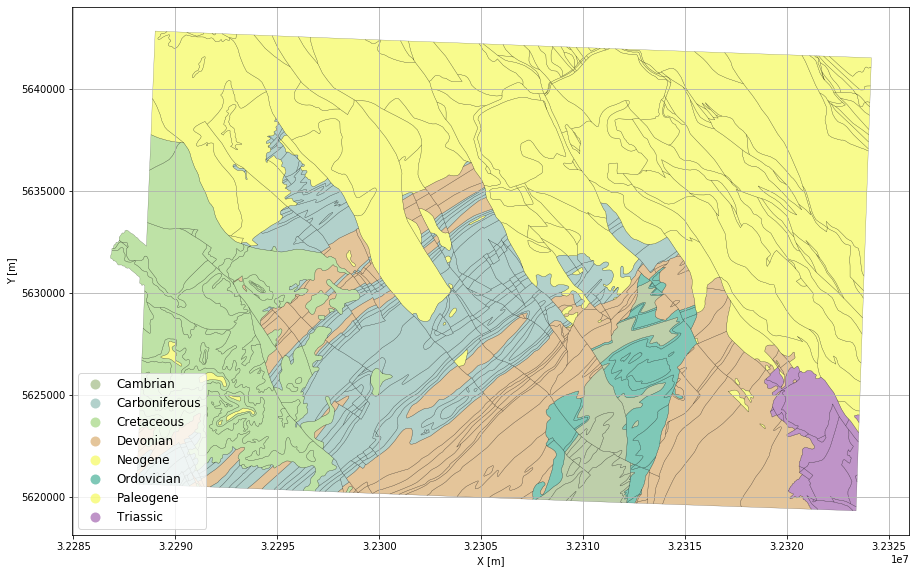

In [3]:
geo = gpd.read_file("data/GeologicalMapAachen.shp")
v, classes = parse_categorized_qml("data/GeologicalMap.qml")
style = pd.DataFrame(build_style_dict(column, classes)).transpose()
geo["Color"] = geo[v].replace(style.color.to_dict())
geo_wgs84 = geo.to_crs(epsg=4326)
print(geo.crs)
cols =[ ('#7fa056'),  ('#67a599'),('#7fc64e'), ('#cb8c37'), ('#f2f91d'), ('#009270'), ('#f2f91d'),('#812b92')]
fig, ax = plt.subplots(figsize=(15,15))
geo.plot(ax = ax, alpha=0.5, edgecolor='k', linewidth=0.3, column='SYSTEM1',legend=True, legend_kwds={'frameon': True,'loc': 'lower left', 'fontsize': 12}, cmap = ListedColormap(cols))
plt.grid()
plt.ylabel('Y [m]')
plt.xlabel('X [m]');

In [4]:
geo.total_bounds

array([32286815.63299858,  5619310.61830153, 32324156.80569947,
        5642854.42190161])

In [5]:
geo.head()

,OBJECTID,SYSTEM2,SERIE2,SSERIE2,STUFE2,SSTUFE2,SYSTEM1,SERIE1,SSERIE1,STUFE1,...,SSYMBOL,EINHEIT1,EINHEIT2,SSY_GSY,GE_GG,GRUTEXT,SHAPE_Leng,SHAPE_Area,geometry,Color
0,131,Devon,Oberdevon,-,Famennium,-,Devonian,Oberdevon,-,Frasnium,...,dfrs+f,Frasnes- und Famenne-Schiefer,-,"dfrs+f,T",4.540300e+10,Tonstein; untergeordnet Kalkmergel- bis Mergel...,459.117585,1.204331e+04,"POLYGON ((32299083.709 5631034.983, 32299164.0...",#cb8c37
1,132,-,-,-,-,-,Neogene,MiozÃ¤n,ObermiozÃ¤n,-,...,mii7,Inden-Formation,-,"mii7,s4",7.000001e+09,Fein- bis Mittelsand; untergeordnet Schluff un...,4409.717252,4.872963e+05,"POLYGON ((32317556.700 5633860.692, 32317497.2...",#f2f91d
2,133,-,-,-,-,-,Neogene,MiozÃ¤n,ObermiozÃ¤n,-,...,mii7,Inden-Formation,-,"mii7,s4",7.000001e+09,Fein- bis Mittelsand; untergeordnet Schluff un...,7644.698585,2.347097e+06,"POLYGON ((32310428.554 5638385.230, 32310400.4...",#f2f91d
3,134,-,-,-,-,-,Cretaceous,Oberkreide,-,Santonium,...,krsah,Aachen-Formation,"Aachen-Formation, Hergenrath-Subformation","krsah,ut",1.740000e+10,Schluff und Ton; untergeordnet Fein- bis Mitte...,19078.933649,2.340703e+06,"POLYGON ((32291096.918 5622295.519, 32290989.7...",#7fc64e
4,135,Devon,Oberdevon,-,Famennium,-,Devonian,Mitteldevon,-,Givetium,...,dgfk,Massenkalk,-,"dgfk,KD",4.680000e+10,Kalkstein und Dolomitstein,4615.886827,4.051250e+05,"POLYGON ((32307344.796 5625848.944, 32307389.6...",#cb8c37


## Loading Raster Data

### Loading DEM

In [6]:
dataset = rasterio.open('data/DEM50_Weisweiler_EPSG4647.tif')
data = dataset.read(1)
data = np.flipud(data)

### Plotting DEM

Text(0, 0.5, 'Y')

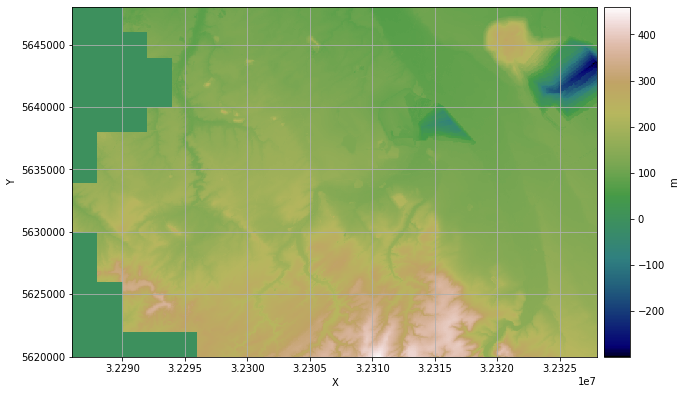

In [7]:
plt.figure(figsize=(10, 10))
ax = plt.gca()

im = ax.imshow(data,origin = 'lower', cmap = 'gist_earth', extent = [32286000,32328000,5620000,5648000] )

plt.grid()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.set_ylabel('m')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

### Calculating and plotting hillshades

Text(79.75, 0.5, 'Y')

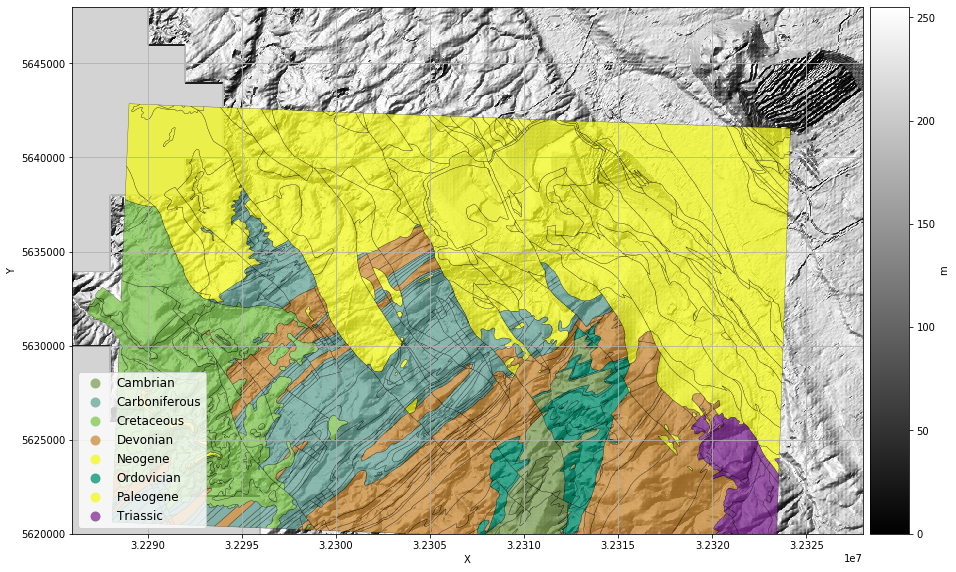

In [8]:
ls = LightSource(azdeg=225, altdeg=45)
hillshades = ls.hillshade(data)
hillshades = hillshades * 255

fig, ax = plt.subplots(figsize=(15,15))
geo.plot(ax = ax, alpha=0.75, edgecolor='k', linewidth=0.3, column='SYSTEM1',legend=True, legend_kwds={'frameon': True,'loc': 'lower left', 'fontsize': 12}, cmap = ListedColormap(cols))

im = ax.imshow(hillshades, origin='lower', cmap = 'gray', extent = [32286000,32328000,5620000,5648000],alpha = 1)
plt.grid()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.set_ylabel('m')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Picking Data

## Create empty dictionaries to store data

In [9]:
atti_source = ColumnDataSource({
    'x': [], 'y': [], 'unit':[], 'dipdir': [], 'dip':[]
})
area_source = ColumnDataSource({"x":[], "y":[], "w":[], "h":[]})
profile_source = ColumnDataSource({"xs":[], "ys":[]})

## Interactively Picking data

***The supported actions include***

Add box or line: ***Hold shift then double click to start drawing, move the mouse and double click again to finish drawing.***

In [11]:
show(bksc)

## Processing Data
### Model Area Data

In [21]:
area_source.data

{'h': [27229.168499156833],
 'w': [42473.97804723005],
 'x': [690251.2436640754],
 'y': [6583335.3334463155]}

### Model Area Data in EPSG:3857

669014.2546404604 711488.2326876904 6569720.749196737 6596949.917695894


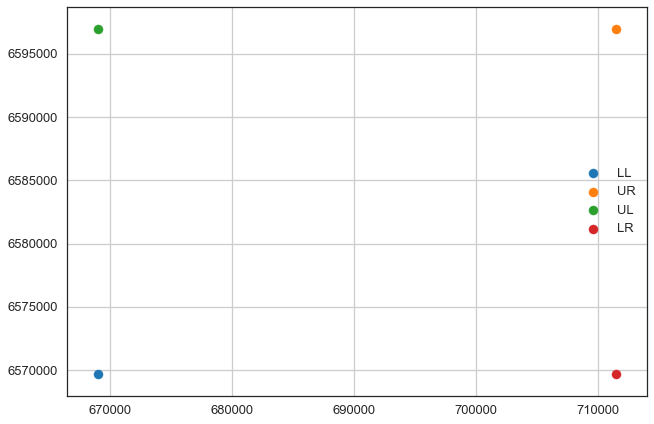

In [26]:
minx = area_source.data['x'][0] - 0.5 * area_source.data['w'][0]
maxx = area_source.data['x'][0] + 0.5 * area_source.data['w'][0]
miny = area_source.data['y'][0] - 0.5 * area_source.data['h'][0]
maxy = area_source.data['y'][0] + 0.5 * area_source.data['h'][0]
print(minx, maxx, miny, maxy)

#The plot is to check that the right points were selected
plt.scatter(minx,miny, label = 'LL')
plt.scatter(maxx, maxy, label = 'UR')
plt.scatter(minx, maxy, label = 'UL')
plt.scatter(maxx, miny, label = 'LR')
plt.legend()
plt.grid()

### Model Area Data in EPSG:4647

In [27]:
from pyproj import Proj
from pyproj import transform

extent = (minx, miny, maxx, maxy)
            
proj_custom = Proj(init='epsg:3857')
proj_deafult = Proj(init='epsg:4647')

extent_transf = np.zeros(4)
extent_transf[0], extent_transf[1] = transform(proj_custom, proj_deafult, extent[0],
                                               extent[1])
extent_transf[2], extent_transf[3] = transform(proj_custom, proj_deafult, extent[2],
                                               extent[3])

extent_transf
minx, miny, maxx, maxy = extent_transf[0], extent_transf[1], extent_transf[2], extent_transf[3]
print(minx, maxx, miny, maxy)


32288885.458720367 32316427.191588134 5621566.723807553 5637740.526835422


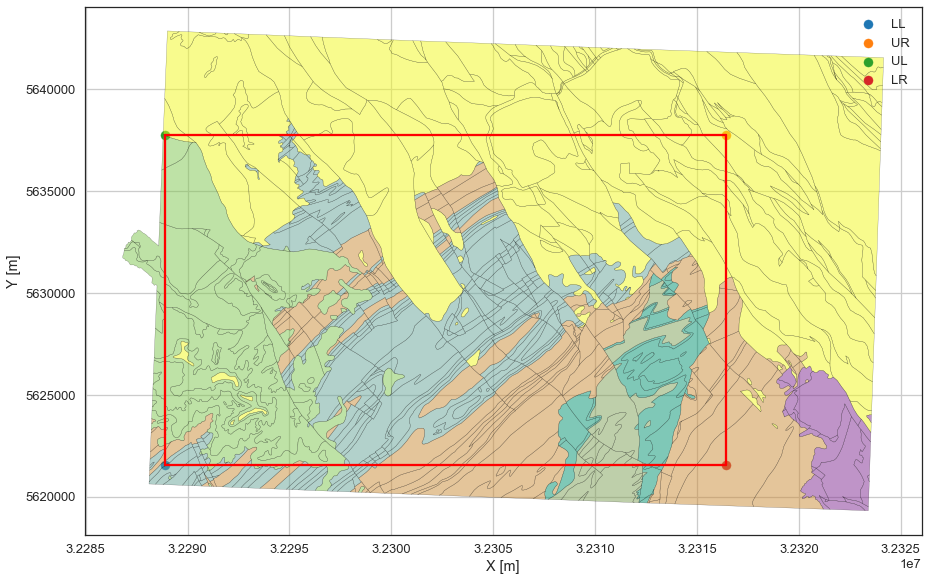

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(minx,miny, label = 'LL')
plt.scatter(maxx, maxy, label = 'UR')
plt.scatter(minx, maxy, label = 'UL')
plt.scatter(maxx, miny, label = 'LR')
plt.plot([minx,minx],[miny, maxy], c = 'red')
plt.plot([maxx,maxx],[miny, maxy], c = 'red')
plt.plot([minx,maxx],[miny, miny], c = 'red')
plt.plot([minx,maxx],[maxy, maxy], c = 'red')
geo.plot(ax = ax, alpha=0.5, edgecolor='k', linewidth=0.3, column='SYSTEM1',legend=True, legend_kwds={'frameon': True,'loc': 'lower left', 'fontsize': 12}, cmap = ListedColormap(cols))
plt.grid()
plt.ylabel('Y [m]')
plt.xlabel('X [m]');
plt.legend()

### Profile Line Data in EPSG:3857

In [ ]:
profile_source.data

In [ ]:
profile_source.data['xs'][0][1]

### Profile Line Data in EPSG:4647

In [ ]:
proj_custom = Proj(init='epsg:3857')
proj_deafult = Proj(init='epsg:4647')


first_point = transform(proj_custom, proj_deafult, profile_source.data['xs'][0][0],profile_source.data['ys'][0][0])
second_point = transform(proj_custom, proj_deafult, profile_source.data['xs'][0][1],profile_source.data['ys'][0][1])

print(first_point, second_point)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(first_point[0],first_point[1], label = 'first', c = 'red')
plt.scatter(second_point[0],second_point[1], label = 'second', c = 'red')
plt.plot([minx,minx],[miny, maxy], c = 'red')
plt.plot([maxx,maxx],[miny, maxy], c = 'red')
plt.plot([minx,maxx],[miny, miny], c = 'red')
plt.plot([minx,maxx],[maxy, maxy], c = 'red')
plt.plot([first_point[0],second_point[0] ], [first_point[1], second_point[1]], c = 'red')
geo.plot(ax = ax, alpha=0.5, edgecolor='k', linewidth=0.3, column='SYSTEM1',legend=True, legend_kwds={'frameon': True,'loc': 'lower left', 'fontsize': 12}, cmap = ListedColormap(cols))
plt.grid()
plt.ylabel('Y [m]')
plt.xlabel('X [m]');
plt.legend()

### Interfaces and Orientation Data

In [ ]:
atti_source.data

### Create Pandas Dataframe

In [ ]:
data = [atti_source.data['x'], atti_source.data['y'], atti_source.data['unit'], atti_source.data['dip'], atti_source.data['dipdir']]

In [ ]:
df = pd.DataFrame(data)
df = df.transpose()
df.columns = ['X', 'Y', 'formation', 'dip', 'azimuth']
df = df.dropna(thresh = 3)
df

In [ ]:
df_edit = df.copy(deep = True)

interfaces = df_edit[df_edit['dip'].isnull()]
interfaces

In [ ]:
pd.options.mode.chained_assignment = None 

proj_custom = Proj(init='epsg:3857')
proj_deafult = Proj(init='epsg:4647')

x = []
y = []
for i in range(len(interfaces)):
    a,b = transform(proj_custom, proj_deafult, interfaces['X'].iloc[i],interfaces['Y'].iloc[i])
    x.append(a)
    y.append(b)

In [ ]:
interfaces['X'] = x
interfaces['Y'] = y
interfaces = interfaces[['X', 'Y', 'formation']]
interfaces

In [ ]:
orientations = df_edit.dropna()
orientations

In [ ]:
pd.options.mode.chained_assignment = None 

proj_custom = Proj(init='epsg:3857')
proj_deafult = Proj(init='epsg:4647')

x = []
y = []
for i in range(len(orientations)):
    a,b = transform(proj_custom, proj_deafult, orientations['X'].iloc[i],orientations['Y'].iloc[i])
    x.append(a)
    y.append(b)

In [ ]:
orientations['X'] = x
orientations['Y'] = y
orientations['polarity'] = 1
orientations = orientations[['X', 'Y', 'formation', 'polarity', 'dip', 'azimuth']]
orientations

## Get altitudes from DEM

In [ ]:
dataset.crs

In [ ]:
coords = [(x,y) for x, y in zip(interfaces['X'], interfaces['Y'])]
interfaces['Z'] = [x[0] for x in dataset.sample(coords)]    

interfaces = interfaces[['X', 'Y', 'Z','formation']]
# interfaces.to_csv('interfaces.csv')
interfaces

In [ ]:
coords = [(x,y) for x, y in zip(orientations['X'], orientations['Y'])]
orientations['Z'] = [x[0] for x in dataset.sample(coords)]    

orientations = orientations[['X', 'Y', 'Z','formation','polarity', 'dip', 'azimuth']]
# orientations.to_csv('orientations.csv')
orientations

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
geo.plot(ax = ax, alpha=0.5, edgecolor='k', linewidth=0.3, column='SYSTEM1',legend=True, legend_kwds={'frameon': True,'loc': 'lower left', 'fontsize': 12}, cmap = ListedColormap(cols))
plt.scatter(first_point[0],first_point[1], label = 'first', c = 'red')
plt.scatter(second_point[0],second_point[1], label = 'second', c = 'red')
plt.plot([minx,minx],[miny, maxy], c = 'red')
plt.plot([maxx,maxx],[miny, maxy], c = 'red')
plt.plot([minx,maxx],[miny, miny], c = 'red')
plt.plot([minx,maxx],[maxy, maxy], c = 'red')
plt.scatter(orientations['X'],orientations['Y'])
plt.scatter(interfaces['X'],interfaces['Y'])
plt.plot([first_point[0],second_point[0] ], [first_point[1], second_point[1]], c = 'red')
plt.grid()
plt.ylabel('Y [m]')
plt.xlabel('X [m]');
plt.legend()

# Create GemPy Model

In [43]:
import sys
sys.path.append('.../.../gemgis/gempy')
import gempy as gp
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('.../...')
import os 
print(gp)
print(gp.__version__)

<module 'gempy' from 'C:/Users/user_abuser/Documents/gemgis/gempy\\gempy\\__init__.py'>
2.2.2


## Create Model

In [85]:
geo_model = gp.create_model('Transform2020')

## Load Data

In [86]:
interfaces = pd.read_csv('data/interfaces.csv', delimiter = ',')
orientations = pd.read_csv('data/orientations.csv', delimiter = ',')

In [87]:
interfaces.head()

,Unnamed: 0,X,Y,Z,formation
0,0,3.230882e+07,5.628151e+06,236.529999,Carboniferous
1,1,3.230566e+07,5.625649e+06,254.789993,Carboniferous
2,2,3.230117e+07,5.622304e+06,261.450012,Carboniferous
3,3,3.231203e+07,5.630208e+06,213.240005,Carboniferous
4,4,3.229150e+07,5.624020e+06,250.949997,Carboniferous


In [88]:
orientations.head()

,Unnamed: 0,X,Y,Z,formation,polarity,dip,azimuth
0,19,3.230530e+07,5.623543e+06,266.910004,Devonian,1,40,315
1,20,3.229640e+07,5.629068e+06,168.869995,Devonian,1,40,135
2,22,3.230427e+07,5.634893e+06,186.320007,Devonian,1,40,135


## Initiate Model

In [89]:
# Model extent form previous clicking
minx = 32288885.458720367   
maxx = 32316427.191588134
miny = 5621566.723807553
maxy = 5637740.526835422
minz = -2600
maxz = 500

gp.init_data(geo_model, [minx, maxx, miny, maxy, minz, maxz], [50, 75, 50],
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Transform2020  2020-06-13 14:11

## Inspect Surfaces

In [90]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Carboniferous,Default series,1,#015482,1
1,Devonian,Default series,2,#9f0052,2


## Map Stack to Surfaces

In [91]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Carboniferous', 'Devonian', 'basement'),
                          },
                         remove_unused_series=True)
geo_model.add_surfaces('basement')
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Carboniferous,Strat_Series,1,#015482,1
1,Devonian,Strat_Series,2,#9f0052,2
2,basement,Strat_Series,3,#ffbe00,3


## Inspect Data Points

In [92]:
gp.get_data(geo_model, 'surface_points')

,X,Y,Z,smooth,surface
0,3.230882e+07,5.628151e+06,236.529999,0.000002,Carboniferous
1,3.230566e+07,5.625649e+06,254.789993,0.000002,Carboniferous
2,3.230117e+07,5.622304e+06,261.450012,0.000002,Carboniferous
3,3.231203e+07,5.630208e+06,213.240005,0.000002,Carboniferous
4,3.229150e+07,5.624020e+06,250.949997,0.000002,Carboniferous
5,3.229559e+07,5.627037e+06,191.000000,0.000002,Carboniferous
6,3.229878e+07,5.630034e+06,177.649994,0.000002,Carboniferous
7,3.230209e+07,5.631968e+06,180.679993,0.000002,Carboniferous
8,3.230519e+07,5.633968e+06,191.339996,0.000002,Carboniferous
9,3.230907e+07,5.636328e+06,151.389999,0.000002,Carboniferous


In [93]:
gp.get_data(geo_model, 'orientations')

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,3.230530e+07,5.623543e+06,266.910004,-0.454519,0.454519,0.766044,0.01,Devonian
1,3.229640e+07,5.629068e+06,168.869995,0.454519,-0.454519,0.766044,0.01,Devonian
2,3.230427e+07,5.634893e+06,186.320007,0.454519,-0.454519,0.766044,0.01,Devonian


## Define custom Section

In [94]:
#Sections for coordinates obtained from previous clicking
section_dict = {'section1': ([32296836.414757043, 5636029.445925801], [32309932.123579897, 5621770.800279849], [100, 80])}
geo_model.set_section_grid(section_dict)

Active grids: ['regular' 'sections']


,start,stop,resolution,dist
section1,"[32296836.414757043, 5636029.445925801]","[32309932.123579897, 5621770.800279849]","[100, 80]",19359.921623


## Plot Input Data

C:/Users/user_abuser/Documents/gemgis/gempy\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


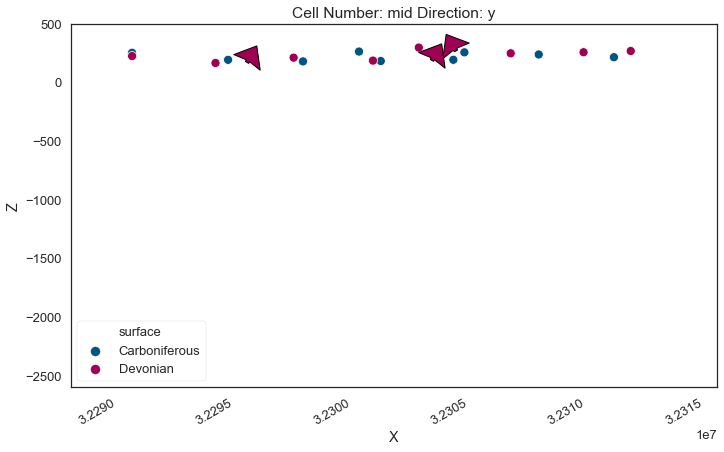

In [95]:
plot = gp.plot_2d(geo_model, show_surfaces=False, show_data=True, show_lith=False, image=False, ve=5)
plt.show()

## Load Topography

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography' 'sections']


C:/Users/user_abuser/Documents/gemgis/gempy\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


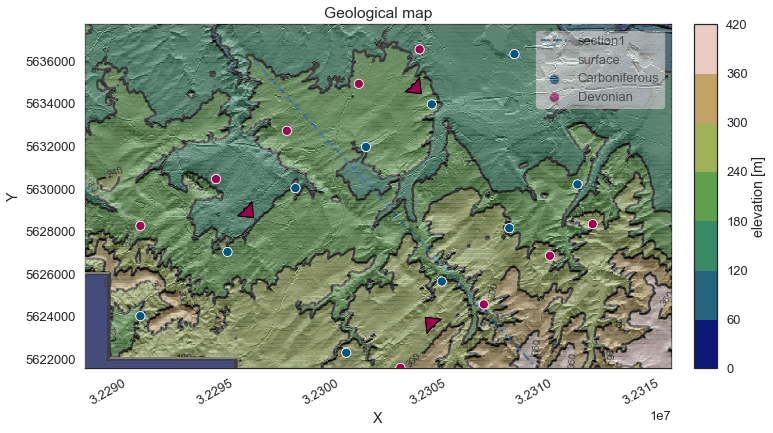

In [96]:
fp='data/DEM50_Weisweiler_EPSG4647.tif'
geo_model.set_topography(source='gdal', filepath=fp)
gp.plot_2d(geo_model, show_topography=True, section_names=['topography'], show_lith=False,
           show_boundaries=False,show_section_traces=True,
           kwargs_topography={'cmap': 'gist_earth', 'norm': None}
           )


## Compile Theano Function

In [97]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                       values
range                32089.7
$C_o$            2.45178e+07
drift equations          [3]


In [98]:
gp.get_data(geo_model, 'kriging')

,values
range,32089.7
$C_o$,2.45178e+07
drift equations,[3]


## Compute Model

In [99]:
sol = gp.compute_model(geo_model)

C:/Users/user_abuser/Documents/gemgis/gempy\gempy\core\solution.py:315: UserWarning: Surfaces not computed due to: module 'skimage.measure' has no attribute 'marching_cubes'. The surface is: Series: module 'skimage.measure' has no attribute 'marching_cubes'; Surface Number:0
  '; Surface Number:' + str(s_n))
C:/Users/user_abuser/Documents/gemgis/gempy\gempy\core\solution.py:315: UserWarning: Surfaces not computed due to: module 'skimage.measure' has no attribute 'marching_cubes'. The surface is: Series: module 'skimage.measure' has no attribute 'marching_cubes'; Surface Number:1
  '; Surface Number:' + str(s_n))


## Plot custom section

C:/Users/user_abuser/Documents/gemgis/gempy\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


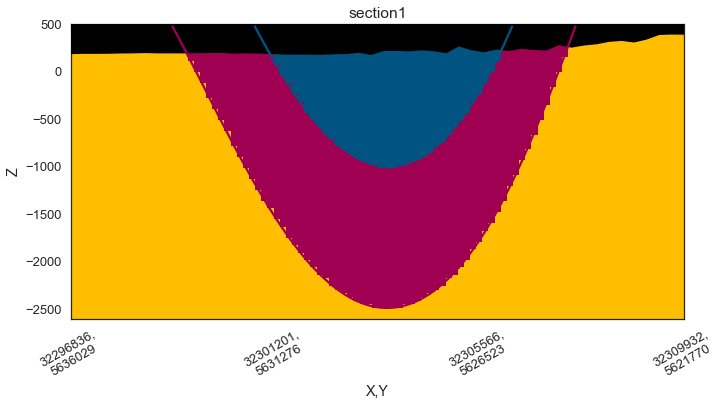

In [100]:
gp.plot_2d(geo_model, section_names=['section1'], ve = 3, show_topography=True)
plt.show()

## Plot Geological Map

ValueError: cannot reshape array of size 177973 into shape (50,75)

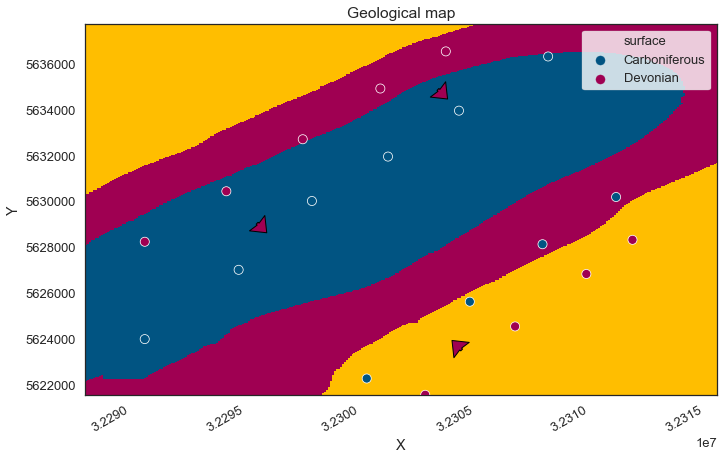

In [101]:
gp.plot_2d(geo_model, section_names=['topography'], show_contours = False)

## Plot 3D Model

In [ ]:
ver, sim = gp.get_surfaces(geo_model)
gpv = gp.plot_3d(geo_model, 
                 show_surfaces=True,
                 show_lith=True, 
                 image=False, 
                 show_results= True,
                 plotter_type='basic', 
                 ve=5)